# Example 4. Karate club network

In this example, we fit SBMs to the famous Zachary's Karate Club network[1]. The university's karate club has split up into two groups due to the internal conflict. The available information is the social interactions of 34 participants outside the club. The task is to separate the individuals into groups using this data, and the members of each faction are known. As the number of connections significantly varies among the persons, it was demonstrated that DCSBM better describes this network as the standard SBM, those treat the node's degree as the main feature[2].

![](karate_dcsbm.png)
#### Zachary's Karate club network divided into groups by DCSBM [2]

[1] W. W. Zachary, An information flow model for conflict and fission in small groups, Journal of Anthropological Research 33, 452-473 (1977).

[2] Brian Karrer and M. E. J. Newman, Stochastic blockmodels and community structure in networks, Phys. Rev. E 83, 016107 (2011).

In [1]:
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
import sys
sys.path.append('../src/')
from vi_sbm import *
from graph_models import SBM, DCSBM, EdgesDataset
import seaborn as sns

torch.manual_seed(42)

We start with the data import and aggregate the links into the adjacency matrix $A$. The true group assignments `z_true` are known.

In [2]:
karate = pd.read_csv('../data/karate', sep=' ')
N = 34
num_classes = 2
A = torch.zeros((N,N))
for e in np.array(karate):
    A[e[0]-1,e[1]-1] = 1
    A[e[1]-1,e[0]-1] = 1
    
z_true = torch.tensor([
    [0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1],
    [1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0]]).t()

Here is the network's adjacency matrix $A$.

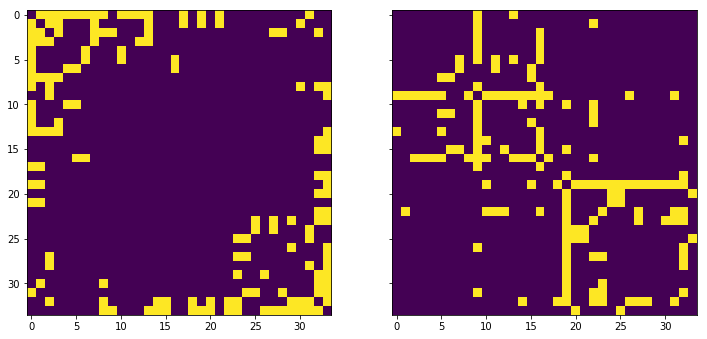

In [3]:
num_class0 = z_true.sum(dim=0)[0].int().item()
order = z_true.argmax(dim=1).argsort()
A_ordered = A[order,:][:,order]
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
axs[0].imshow(A) 
axs[1].imshow(A_ordered) 
plt.show()

## SBM

First, we try the standard SBM. The default prior distribution in `VIRGMo` is quite flat but for this example we may use a more sharp one. We assume that the sizes of both groups are similar, and the nodes are connected densely within the groups as outside.

In [4]:
theta_p = torch.ones([num_classes])*5
w_p = torch.tensor([
        [[9., 1.], [1., 9.]],
        [[1., 9.], [9., 1.]]
        ])

dataloader = DataLoader(EdgesDataset(A.float()), 
                        batch_size=N, shuffle=True, num_workers=0)

vi = VI_SBM(num_nodes=N, num_classes=num_classes, 
                   priors={'theta_p':theta_p, 
                           'B_p':w_p},
                   init_values={'etas':None, 
                                'thetas':None, 
                                'Bs':None})
vi.multi_train(dataloader, epochs=20, lrs = [0.1, 0.05, 0.01], trials=20)

>>>>>>> Training iteration #1 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.10 | Total loss: 871.85 | Epoch time 0.11
Epoch 2 | LR: 0.10 | Total loss: 645.17 | Epoch time 0.07
Epoch 3 | LR: 0.10 | Total loss: 604.40 | Epoch time 0.12
Epoch 4 | LR: 0.10 | Total loss: 576.89 | Epoch time 0.08
Epoch 5 | LR: 0.10 | Total loss: 553.51 | Epoch time 0.08
Epoch 6 | LR: 0.10 | Total loss: 533.84 | Epoch time 0.10
Epoch 7 | LR: 0.10 | Total loss: 517.78 | Epoch time 0.09
Epoch 8 | LR: 0.10 | Total loss: 505.07 | Epoch time 0.09
Epoch 9 | LR: 0.10 | Total loss: 494.73 | Epoch time 0.15
Epoch 10 | LR: 0.10 | Total loss: 486.17 | Epoch time 0.16
Epoch 11 | LR: 0.10 | Total loss: 479.02 | Epoch time 0.19
Epoch 12 | LR: 0.10 | Total loss: 473.04 | Epoch time 0.09
Epoch 13 | LR: 0.10 | Total loss: 467.91 | Epoch time 0.09
Epoch 14 | LR: 0.10 | Total loss: 463.69 | Epoch time 0.17
Epoch 15 | LR: 0.10 | Total loss: 459.99 | Epoch time 0.13
Epoch 16 | LR: 0.10 | Total loss: 456.78 | Epoch time 0.14
Ep

Epoch 16 | LR: 0.10 | Total loss: 461.52 | Epoch time 0.10
Epoch 17 | LR: 0.10 | Total loss: 458.50 | Epoch time 0.08
Epoch 18 | LR: 0.10 | Total loss: 454.93 | Epoch time 0.08
Epoch 19 | LR: 0.10 | Total loss: 452.17 | Epoch time 0.09
Epoch 20 | LR: 0.10 | Total loss: 449.79 | Epoch time 0.08
Epoch 21 | LR: 0.05 | Total loss: 447.27 | Epoch time 0.07
Epoch 22 | LR: 0.05 | Total loss: 445.67 | Epoch time 0.09
Epoch 23 | LR: 0.05 | Total loss: 443.93 | Epoch time 0.08
Epoch 24 | LR: 0.05 | Total loss: 442.26 | Epoch time 0.08
Epoch 25 | LR: 0.05 | Total loss: 440.87 | Epoch time 0.09
Epoch 26 | LR: 0.05 | Total loss: 439.63 | Epoch time 0.09
Epoch 27 | LR: 0.05 | Total loss: 438.65 | Epoch time 0.07
Epoch 28 | LR: 0.05 | Total loss: 437.16 | Epoch time 0.11
Epoch 29 | LR: 0.05 | Total loss: 436.61 | Epoch time 0.07
Epoch 30 | LR: 0.05 | Total loss: 435.40 | Epoch time 0.08
Epoch 31 | LR: 0.05 | Total loss: 434.87 | Epoch time 0.09
Epoch 32 | LR: 0.05 | Total loss: 433.76 | Epoch time 0.

Epoch 32 | LR: 0.05 | Total loss: 492.89 | Epoch time 0.11
Epoch 33 | LR: 0.05 | Total loss: 492.79 | Epoch time 0.11
Epoch 34 | LR: 0.05 | Total loss: 492.63 | Epoch time 0.12
Epoch 35 | LR: 0.05 | Total loss: 492.27 | Epoch time 0.10
Epoch 36 | LR: 0.05 | Total loss: 491.83 | Epoch time 0.11
Epoch 37 | LR: 0.05 | Total loss: 491.45 | Epoch time 0.11
Epoch 38 | LR: 0.05 | Total loss: 491.44 | Epoch time 0.10
Epoch 39 | LR: 0.05 | Total loss: 491.00 | Epoch time 0.11
Epoch 40 | LR: 0.05 | Total loss: 490.30 | Epoch time 0.10
Epoch 41 | LR: 0.01 | Total loss: 490.72 | Epoch time 0.11
Epoch 42 | LR: 0.01 | Total loss: 490.79 | Epoch time 0.10
Epoch 43 | LR: 0.01 | Total loss: 490.75 | Epoch time 0.11
Epoch 44 | LR: 0.01 | Total loss: 490.25 | Epoch time 0.13
Epoch 45 | LR: 0.01 | Total loss: 490.07 | Epoch time 0.11
Epoch 46 | LR: 0.01 | Total loss: 489.99 | Epoch time 0.11
Epoch 47 | LR: 0.01 | Total loss: 489.96 | Epoch time 0.11
Epoch 48 | LR: 0.01 | Total loss: 489.43 | Epoch time 0.

Epoch 49 | LR: 0.01 | Total loss: 427.46 | Epoch time 0.10
Epoch 50 | LR: 0.01 | Total loss: 427.65 | Epoch time 0.12
Epoch 51 | LR: 0.01 | Total loss: 427.37 | Epoch time 0.11
Epoch 52 | LR: 0.01 | Total loss: 427.18 | Epoch time 0.11
Epoch 53 | LR: 0.01 | Total loss: 426.93 | Epoch time 0.11
Epoch 54 | LR: 0.01 | Total loss: 426.50 | Epoch time 0.10
Epoch 55 | LR: 0.01 | Total loss: 426.29 | Epoch time 0.11
Epoch 56 | LR: 0.01 | Total loss: 426.32 | Epoch time 0.11
Epoch 57 | LR: 0.01 | Total loss: 426.39 | Epoch time 0.12
Epoch 58 | LR: 0.01 | Total loss: 426.17 | Epoch time 0.11
Epoch 59 | LR: 0.01 | Total loss: 425.71 | Epoch time 0.10
Epoch 60 | LR: 0.01 | Total loss: 425.63 | Epoch time 0.16
>>>>>>>>>>>> Training is finished.

>>>>>>> Training iteration #8 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.10 | Total loss: 715.52 | Epoch time 0.12
Epoch 2 | LR: 0.10 | Total loss: 600.83 | Epoch time 0.11
Epoch 3 | LR: 0.10 | Total loss: 571.10 | Epoch time 0.17
Epoch 4 | LR: 0.10 

Epoch 4 | LR: 0.10 | Total loss: 554.96 | Epoch time 0.19
Epoch 5 | LR: 0.10 | Total loss: 535.49 | Epoch time 0.12
Epoch 6 | LR: 0.10 | Total loss: 519.30 | Epoch time 0.11
Epoch 7 | LR: 0.10 | Total loss: 505.62 | Epoch time 0.15
Epoch 8 | LR: 0.10 | Total loss: 494.26 | Epoch time 0.19
Epoch 9 | LR: 0.10 | Total loss: 485.23 | Epoch time 0.18
Epoch 10 | LR: 0.10 | Total loss: 477.55 | Epoch time 0.16
Epoch 11 | LR: 0.10 | Total loss: 471.26 | Epoch time 0.18
Epoch 12 | LR: 0.10 | Total loss: 466.26 | Epoch time 0.18
Epoch 13 | LR: 0.10 | Total loss: 461.50 | Epoch time 0.18
Epoch 14 | LR: 0.10 | Total loss: 458.06 | Epoch time 0.19
Epoch 15 | LR: 0.10 | Total loss: 454.44 | Epoch time 0.11
Epoch 16 | LR: 0.10 | Total loss: 451.72 | Epoch time 0.10
Epoch 17 | LR: 0.10 | Total loss: 449.21 | Epoch time 0.11
Epoch 18 | LR: 0.10 | Total loss: 447.37 | Epoch time 0.11
Epoch 19 | LR: 0.10 | Total loss: 445.08 | Epoch time 0.19
Epoch 20 | LR: 0.10 | Total loss: 443.66 | Epoch time 0.12
Epo

Epoch 21 | LR: 0.05 | Total loss: 443.32 | Epoch time 0.09
Epoch 22 | LR: 0.05 | Total loss: 442.06 | Epoch time 0.11
Epoch 23 | LR: 0.05 | Total loss: 440.81 | Epoch time 0.12
Epoch 24 | LR: 0.05 | Total loss: 439.74 | Epoch time 0.11
Epoch 25 | LR: 0.05 | Total loss: 439.02 | Epoch time 0.10
Epoch 26 | LR: 0.05 | Total loss: 437.74 | Epoch time 0.12
Epoch 27 | LR: 0.05 | Total loss: 437.16 | Epoch time 0.13
Epoch 28 | LR: 0.05 | Total loss: 436.19 | Epoch time 0.11
Epoch 29 | LR: 0.05 | Total loss: 435.61 | Epoch time 0.10
Epoch 30 | LR: 0.05 | Total loss: 435.00 | Epoch time 0.11
Epoch 31 | LR: 0.05 | Total loss: 434.08 | Epoch time 0.13
Epoch 32 | LR: 0.05 | Total loss: 433.53 | Epoch time 0.11
Epoch 33 | LR: 0.05 | Total loss: 433.26 | Epoch time 0.13
Epoch 34 | LR: 0.05 | Total loss: 432.48 | Epoch time 0.10
Epoch 35 | LR: 0.05 | Total loss: 432.35 | Epoch time 0.13
Epoch 36 | LR: 0.05 | Total loss: 431.84 | Epoch time 0.11
Epoch 37 | LR: 0.05 | Total loss: 431.36 | Epoch time 0.

Epoch 39 | LR: 0.05 | Total loss: 430.64 | Epoch time 0.13
Epoch 40 | LR: 0.05 | Total loss: 430.21 | Epoch time 0.09
Epoch 41 | LR: 0.01 | Total loss: 430.27 | Epoch time 0.10
Epoch 42 | LR: 0.01 | Total loss: 429.82 | Epoch time 0.11
Epoch 43 | LR: 0.01 | Total loss: 429.46 | Epoch time 0.10
Epoch 44 | LR: 0.01 | Total loss: 429.31 | Epoch time 0.10
Epoch 45 | LR: 0.01 | Total loss: 428.96 | Epoch time 0.12
Epoch 46 | LR: 0.01 | Total loss: 428.57 | Epoch time 0.10
Epoch 47 | LR: 0.01 | Total loss: 428.34 | Epoch time 0.10
Epoch 48 | LR: 0.01 | Total loss: 428.25 | Epoch time 0.12
Epoch 49 | LR: 0.01 | Total loss: 427.95 | Epoch time 0.10
Epoch 50 | LR: 0.01 | Total loss: 427.80 | Epoch time 0.11
Epoch 51 | LR: 0.01 | Total loss: 427.44 | Epoch time 0.12
Epoch 52 | LR: 0.01 | Total loss: 427.64 | Epoch time 0.12
Epoch 53 | LR: 0.01 | Total loss: 427.34 | Epoch time 0.10
Epoch 54 | LR: 0.01 | Total loss: 426.84 | Epoch time 0.10
Epoch 55 | LR: 0.01 | Total loss: 426.63 | Epoch time 0.

Epoch 55 | LR: 0.01 | Total loss: 426.30 | Epoch time 0.12
Epoch 56 | LR: 0.01 | Total loss: 426.25 | Epoch time 0.11
Epoch 57 | LR: 0.01 | Total loss: 425.81 | Epoch time 0.11
Epoch 58 | LR: 0.01 | Total loss: 425.81 | Epoch time 0.10
Epoch 59 | LR: 0.01 | Total loss: 425.86 | Epoch time 0.10
Epoch 60 | LR: 0.01 | Total loss: 425.62 | Epoch time 0.12
>>>>>>>>>>>> Training is finished.

>>>>>>> Training iteration #17 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.10 | Total loss: 707.67 | Epoch time 0.12
Epoch 2 | LR: 0.10 | Total loss: 579.45 | Epoch time 0.10
Epoch 3 | LR: 0.10 | Total loss: 552.52 | Epoch time 0.12
Epoch 4 | LR: 0.10 | Total loss: 532.93 | Epoch time 0.11
Epoch 5 | LR: 0.10 | Total loss: 516.85 | Epoch time 0.11
Epoch 6 | LR: 0.10 | Total loss: 504.02 | Epoch time 0.11
Epoch 7 | LR: 0.10 | Total loss: 492.91 | Epoch time 0.11
Epoch 8 | LR: 0.10 | Total loss: 484.27 | Epoch time 0.11
Epoch 9 | LR: 0.10 | Total loss: 477.07 | Epoch time 0.11
Epoch 10 | LR: 0.10 | To

Epoch 11 | LR: 0.10 | Total loss: 477.17 | Epoch time 0.12
Epoch 12 | LR: 0.10 | Total loss: 471.55 | Epoch time 0.11
Epoch 13 | LR: 0.10 | Total loss: 466.82 | Epoch time 0.11
Epoch 14 | LR: 0.10 | Total loss: 462.68 | Epoch time 0.11
Epoch 15 | LR: 0.10 | Total loss: 458.82 | Epoch time 0.12
Epoch 16 | LR: 0.10 | Total loss: 456.17 | Epoch time 0.11
Epoch 17 | LR: 0.10 | Total loss: 453.37 | Epoch time 0.09
Epoch 18 | LR: 0.10 | Total loss: 451.38 | Epoch time 0.11
Epoch 19 | LR: 0.10 | Total loss: 448.71 | Epoch time 0.10
Epoch 20 | LR: 0.10 | Total loss: 446.89 | Epoch time 0.10
Epoch 21 | LR: 0.05 | Total loss: 445.31 | Epoch time 0.12
Epoch 22 | LR: 0.05 | Total loss: 444.06 | Epoch time 0.11
Epoch 23 | LR: 0.05 | Total loss: 442.66 | Epoch time 0.11
Epoch 24 | LR: 0.05 | Total loss: 441.45 | Epoch time 0.10
Epoch 25 | LR: 0.05 | Total loss: 440.17 | Epoch time 0.10
Epoch 26 | LR: 0.05 | Total loss: 439.11 | Epoch time 0.11
Epoch 27 | LR: 0.05 | Total loss: 438.57 | Epoch time 0.

In [5]:
best_trial = vi.get_multi_losses()[:,-1].argmin()   # With the smallest loss ar the end

In [6]:
vi.load_state_dict(vi.state_dicts[best_trial])      # Load the parameters from the best trial
q_eta, q_theta, q_B = vi.constrained_params()

In [7]:
vi.multi_results[1][best_trial]                     # Class probability of the best trial

tensor([0.7551, 0.2449])

In [27]:
print('True class probabilities:', z_true.sum(dim=0).float()/34)

True class probabilities: tensor([0.5294, 0.4706])


We see that the standard SBM struggles to find the correct class probabilities $\theta$. Let us look at the accuracy of the class assignments in all trials.

In [9]:
for i in range(len(vi.multi_results[0])):
    print(vi.class_accuracy(z_true,vi.multi_results[0][i]).item())

0.5588235259056091
0.5588235259056091
0.5588235259056091
0.5588235259056091
0.529411792755127
0.5588235259056091
0.5588235259056091
0.5588235259056091
0.5588235259056091
0.5588235259056091
0.5588235259056091
0.5588235259056091
0.5588235259056091
0.5588235259056091
0.5588235259056091
0.5588235259056091
0.5588235259056091
0.5588235259056091
0.5588235259056091
0.5588235259056091


It is clear that the standart SBM does not suit for this task. Next, we try the DCSBM.

## DCSBM

Here, we use the same prior as for the SBM. As in the preivious examples we initialize $\delta$ with the observed degree distributions.

In [10]:
theta_p = torch.ones([num_classes])*5
w_p = torch.tensor([
        [[9., 1.], [1., 9.]],
        [[1., 9.], [9., 1.]]
        ])

In [11]:
delta_init = torch.ones([N,2])
delta_mu = A.sum(dim=1)/A.sum(dim=1).mean()
delta_init[:,0]=delta_mu.log().clone()
print('Contains infinities:', bool(torch.isinf(delta_init).sum().item()))

Contains infinities: False


In [12]:
dataloader = DataLoader(EdgesDataset(torch.tensor(A).float()), 
                        batch_size=N, shuffle=True, num_workers=0)

vi = VI_DCSBM(num_nodes=N, num_classes=num_classes, 
                   priors={'theta_p':theta_p, 
                           'B_p':w_p,
                           'delta_p':None},
                   init_values={'etas':None, 
                                'thetas':None, 
                                'Bs':None,
                                'deltas':delta_init})
vi.multi_train(dataloader, epochs=20, lrs = [0.1, 0.05, 0.01], trials=10)

>>>>>>> Training iteration #1 

>>>>>>>>>>>> Start training...


 /home/mo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor). 


Epoch 1 | LR: 0.10 | Total loss: 492.14 | Epoch time 0.35
Epoch 2 | LR: 0.10 | Total loss: 455.81 | Epoch time 0.24
Epoch 3 | LR: 0.10 | Total loss: 444.23 | Epoch time 0.35
Epoch 4 | LR: 0.10 | Total loss: 437.11 | Epoch time 0.30
Epoch 5 | LR: 0.10 | Total loss: 429.21 | Epoch time 0.31
Epoch 6 | LR: 0.10 | Total loss: 433.13 | Epoch time 0.18
Epoch 7 | LR: 0.10 | Total loss: 426.01 | Epoch time 0.21
Epoch 8 | LR: 0.10 | Total loss: 429.96 | Epoch time 0.16
Epoch 9 | LR: 0.10 | Total loss: 426.99 | Epoch time 0.20
Epoch 10 | LR: 0.10 | Total loss: 426.38 | Epoch time 0.17
Epoch 11 | LR: 0.10 | Total loss: 422.59 | Epoch time 0.20
Epoch 12 | LR: 0.10 | Total loss: 423.63 | Epoch time 0.17
Epoch 13 | LR: 0.10 | Total loss: 423.27 | Epoch time 0.20
Epoch 14 | LR: 0.10 | Total loss: 424.38 | Epoch time 0.16
Epoch 15 | LR: 0.10 | Total loss: 418.90 | Epoch time 0.25
Epoch 16 | LR: 0.10 | Total loss: 419.93 | Epoch time 0.16
Epoch 17 | LR: 0.10 | Total loss: 413.22 | Epoch time 0.19
Epoch 

Epoch 17 | LR: 0.10 | Total loss: 388.39 | Epoch time 0.24
Epoch 18 | LR: 0.10 | Total loss: 383.09 | Epoch time 0.16
Epoch 19 | LR: 0.10 | Total loss: 379.46 | Epoch time 0.19
Epoch 20 | LR: 0.10 | Total loss: 370.07 | Epoch time 0.16
Epoch 21 | LR: 0.05 | Total loss: 374.76 | Epoch time 0.17
Epoch 22 | LR: 0.05 | Total loss: 369.96 | Epoch time 0.16
Epoch 23 | LR: 0.05 | Total loss: 366.94 | Epoch time 0.19
Epoch 24 | LR: 0.05 | Total loss: 365.02 | Epoch time 0.16
Epoch 25 | LR: 0.05 | Total loss: 360.59 | Epoch time 0.18
Epoch 26 | LR: 0.05 | Total loss: 365.70 | Epoch time 0.17
Epoch 27 | LR: 0.05 | Total loss: 361.01 | Epoch time 0.18
Epoch 28 | LR: 0.05 | Total loss: 364.70 | Epoch time 0.16
Epoch 29 | LR: 0.05 | Total loss: 360.82 | Epoch time 0.18
Epoch 30 | LR: 0.05 | Total loss: 361.97 | Epoch time 0.17
Epoch 31 | LR: 0.05 | Total loss: 360.74 | Epoch time 0.18
Epoch 32 | LR: 0.05 | Total loss: 358.44 | Epoch time 0.16
Epoch 33 | LR: 0.05 | Total loss: 358.61 | Epoch time 0.

Epoch 33 | LR: 0.05 | Total loss: 358.56 | Epoch time 0.19
Epoch 34 | LR: 0.05 | Total loss: 355.22 | Epoch time 0.16
Epoch 35 | LR: 0.05 | Total loss: 357.89 | Epoch time 0.17
Epoch 36 | LR: 0.05 | Total loss: 356.41 | Epoch time 0.17
Epoch 37 | LR: 0.05 | Total loss: 355.20 | Epoch time 0.17
Epoch 38 | LR: 0.05 | Total loss: 357.29 | Epoch time 0.16
Epoch 39 | LR: 0.05 | Total loss: 354.91 | Epoch time 0.20
Epoch 40 | LR: 0.05 | Total loss: 355.50 | Epoch time 0.15
Epoch 41 | LR: 0.01 | Total loss: 357.03 | Epoch time 0.18
Epoch 42 | LR: 0.01 | Total loss: 356.05 | Epoch time 0.16
Epoch 43 | LR: 0.01 | Total loss: 355.14 | Epoch time 0.17
Epoch 44 | LR: 0.01 | Total loss: 353.50 | Epoch time 0.17
Epoch 45 | LR: 0.01 | Total loss: 354.89 | Epoch time 0.18
Epoch 46 | LR: 0.01 | Total loss: 353.45 | Epoch time 0.16
Epoch 47 | LR: 0.01 | Total loss: 354.04 | Epoch time 0.18
Epoch 48 | LR: 0.01 | Total loss: 349.31 | Epoch time 0.17
Epoch 49 | LR: 0.01 | Total loss: 354.06 | Epoch time 0.

Epoch 49 | LR: 0.01 | Total loss: 355.31 | Epoch time 0.24
Epoch 50 | LR: 0.01 | Total loss: 355.42 | Epoch time 0.22
Epoch 51 | LR: 0.01 | Total loss: 355.70 | Epoch time 0.32
Epoch 52 | LR: 0.01 | Total loss: 352.23 | Epoch time 0.19
Epoch 53 | LR: 0.01 | Total loss: 354.40 | Epoch time 0.29
Epoch 54 | LR: 0.01 | Total loss: 353.00 | Epoch time 0.29
Epoch 55 | LR: 0.01 | Total loss: 354.81 | Epoch time 0.18
Epoch 56 | LR: 0.01 | Total loss: 353.66 | Epoch time 0.25
Epoch 57 | LR: 0.01 | Total loss: 356.04 | Epoch time 0.29
Epoch 58 | LR: 0.01 | Total loss: 355.11 | Epoch time 0.30
Epoch 59 | LR: 0.01 | Total loss: 353.27 | Epoch time 0.26
Epoch 60 | LR: 0.01 | Total loss: 350.66 | Epoch time 0.31
>>>>>>>>>>>> Training is finished.

>>>>>>> Training iteration #8 

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.10 | Total loss: 451.14 | Epoch time 0.29
Epoch 2 | LR: 0.10 | Total loss: 433.42 | Epoch time 0.22
Epoch 3 | LR: 0.10 | Total loss: 432.12 | Epoch time 0.17
Epoch 4 | LR: 0.10 

Epoch 5 | LR: 0.10 | Total loss: 424.09 | Epoch time 0.17
Epoch 6 | LR: 0.10 | Total loss: 427.98 | Epoch time 0.16
Epoch 7 | LR: 0.10 | Total loss: 423.92 | Epoch time 0.17
Epoch 8 | LR: 0.10 | Total loss: 424.38 | Epoch time 0.16
Epoch 9 | LR: 0.10 | Total loss: 420.47 | Epoch time 0.18
Epoch 10 | LR: 0.10 | Total loss: 421.72 | Epoch time 0.17
Epoch 11 | LR: 0.10 | Total loss: 422.10 | Epoch time 0.17
Epoch 12 | LR: 0.10 | Total loss: 418.30 | Epoch time 0.16
Epoch 13 | LR: 0.10 | Total loss: 418.72 | Epoch time 0.18
Epoch 14 | LR: 0.10 | Total loss: 418.62 | Epoch time 0.16
Epoch 15 | LR: 0.10 | Total loss: 417.64 | Epoch time 0.18
Epoch 16 | LR: 0.10 | Total loss: 418.04 | Epoch time 0.17
Epoch 17 | LR: 0.10 | Total loss: 418.52 | Epoch time 0.17
Epoch 18 | LR: 0.10 | Total loss: 412.52 | Epoch time 0.17
Epoch 19 | LR: 0.10 | Total loss: 414.95 | Epoch time 0.18
Epoch 20 | LR: 0.10 | Total loss: 413.46 | Epoch time 0.16
Epoch 21 | LR: 0.05 | Total loss: 410.34 | Epoch time 0.19
Ep

In [13]:
best_trial = vi.get_multi_losses()[:,-1].argmin()   # With the smallest loss ar the end

In [14]:
vi.load_state_dict(vi.state_dicts[best_trial])      # Load the parameters from the best trial
q_eta, q_theta, q_B, q_delta = vi.constrained_params()

In [15]:
vi.multi_results[1][best_trial]                     # Class probability of the best trial

tensor([0.4748, 0.5252])

In [22]:
theta_true = z_true.sum(dim=0).float()/34

In [23]:
print('True class probabilities:', theta_true)

True class probabilities: tensor([0.5294, 0.4706])


Again, let us look at the class acuracy.

In [24]:
for i in range(len(vi.multi_results[0])):
    print(vi.class_accuracy(z_true,vi.multi_results[0][i]).item())

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


The class assignments of the DCSBM is correct in the majority of the trials. Further, we may inspect the estimated $\theta$ and $B$ distributions.

In [25]:
permutation = [1,0]
q_theta_perm = q_theta.detach()[permutation]
num_samples = 1000
theta_samples = Dirichlet(q_theta_perm).sample([num_samples])

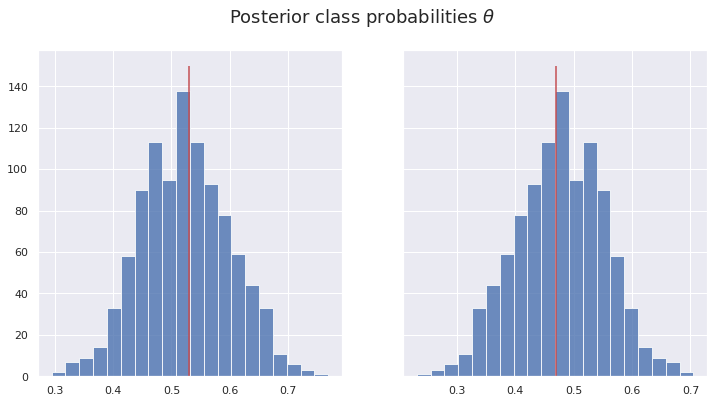

In [26]:
sns.set()
fig, axs = plt.subplots(1, num_classes, figsize=(12, 6), sharey=True)
bins, alpha = 20, 0.8
for i in range(num_classes):
    axs[i].hist(theta_samples[:,i], bins=bins, alpha=alpha) 
    axs[i].vlines(theta_true[i], 0, num_samples*0.15, colors='r')
fig.suptitle(r'Posterior class probabilities $\theta$', fontsize=18)
plt.show()

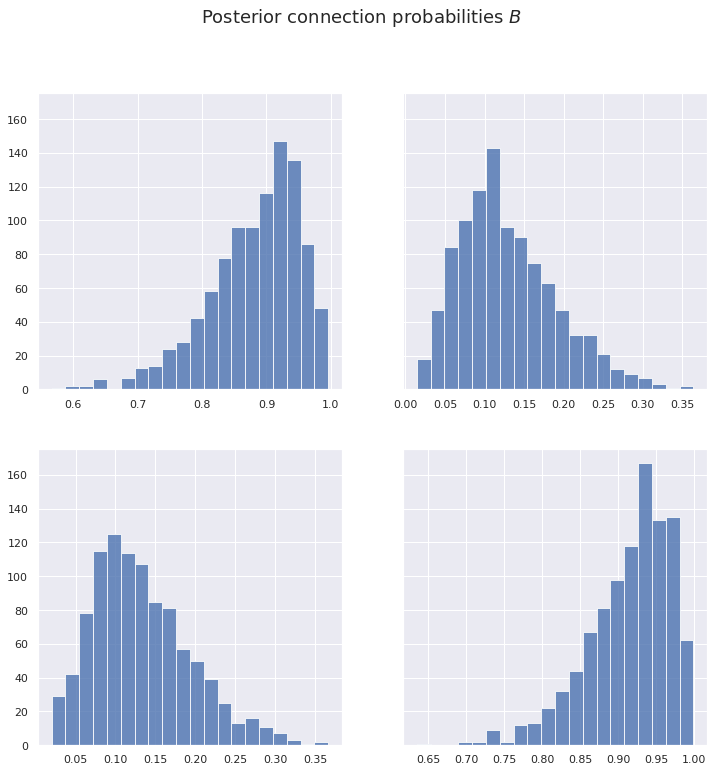

In [21]:
q_B_perm = q_B.detach()[permutation,:,:][:,permutation,:]
B_samples = Beta(q_B_perm[:,:,0], q_B_perm[:,:,1]).sample([num_samples])

fig, axs = plt.subplots(num_classes, num_classes, figsize=(12, 12), sharey=True)
bins, alpha = 20, 0.8
for i in range(num_classes):
    for j in range(num_classes):
        axs[i,j].hist(B_samples[:,i, j], bins=bins, alpha=alpha) 
fig.suptitle(r'Posterior connection probabilities $B$', fontsize=18)
plt.show()